# The doubling population

Let's play with very simple scenario with a few (simple) mathematical models. The purpose of this exploration is not necessarily to explore the models, but rather to see various bits of Julia syntax and style for dealing with basic analysis.

**Say we observe or believe that every day the population doubles (and there are no deaths)**

Here are some 6 different models for this ...

### Model 1 (discrete time/deterministic)

$$
x(t+1) = \alpha x(t)
$$

with $\alpha = 2$.

### Model 2 (continuous time/deterministic)

$$
\frac{d}{dt} x(t) = \kappa x(t)
$$

with $\kappa = \log(\alpha) = \log(2) \approx 0.693$.

### Model 3 (discrete time/stochastic)

$$
x(t+1) = \sum_{i=1}^{x(t)} \xi_{i,t}
$$

with $E[\xi_{i,t}] = \alpha = 2$.

### Model 4 (continuous time/stochastic/continuous trajectory)

$$
du(t) = \kappa u(t) + d \zeta(t).
$$

And $x(t) = \max(u(t),0)$.

### Model 5 (continuous time/stochastic/discrete trajectory)

A continuous time markov chain with transition rates: $x \to x+1$ at rate $\kappa x$.

### Model 6 (continuous time/stochastic/discrete trajectory/non-Markovian)

A continuous time processs where each doubling per agent has their own distribution.

Let's create trajectories for each of these models over the time horizon $[0,5]$. For the stochastic models lets compute mean trajectories. For those models let's also look at the distribution of $x(t=5)$. 

---

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/git/mine/Workshop_Julia_for_Biologists`


In [2]:
using Plots, DifferentialEquations, Distributions, Random

In [3]:
const α_const = 2 #\alpha + [TAB]
const κ_const = log(2) #\kappa + [TAB]
const default_t_max = 5
const default_x0 = 1.0;

In [4]:
"""
A generic structure that represents a model trajectory. 

* `t` is treated as an indexable object (array) of times.
* `u` is treated as an indexable object (array) or the trajectory.

This struct can be used in place of outputs of solvers of `DifferentialEquations.jl`
"""
struct ModelTrajectory
    t
    u
end

ModelTrajectory

In [5]:
? ModelTrajectory

search: ModelTrajectory



A generic structure that represents a model trajectory. 

  * `t` is treated as an indexable object (array) of times.
  * `u` is treated as an indexable object (array) or the trajectory.

This struct can be used in place of outputs of solvers of `DifferentialEquations.jl`


In [6]:
"""
Create a trajectory for model 1.
"""
function model_1_traj(;t_max = default_t_max, x0 = default_x0)
    traj = Array{Float64}(undef, t_max+1)
    x = x0
    traj[1] = x
    for t in 2:(t_max+1)
        x *= α_const
        traj[t] = x
    end
    return ModelTrajectory(0:t_max, traj)
end

model_1_traj

In [7]:
traj1 = model_1_traj()
traj1.t, traj1.u

(0:5, [1.0, 2.0, 4.0, 8.0, 16.0, 32.0])

Let's create a function for querying/interpolating a trajectory at any given time (within the time range).

In [8]:
function value_at_time(mt, time::Real) #mt is like ModelTrajectory assumed to have fields t, and u
    time < first(mt.t) && error("Time preceeds trajectory")
    i = findfirst((t)->t≥time, mt.t) 
    i == nothing && error("Time exceeds trajectory")
    t1, u1 = mt.t[i], mt.u[i]
    
    #if exact match of time 
    t1 == time && return u1

    #If here then interporlate
    @assert i > 1
    iprev = i-1
    tprev, uprev = mt.t[iprev], mt.u[iprev]
    return uprev + (time-tprev)/(t1-tprev) * (u1-uprev) #interpolate  
end

value_at_time (generic function with 1 method)

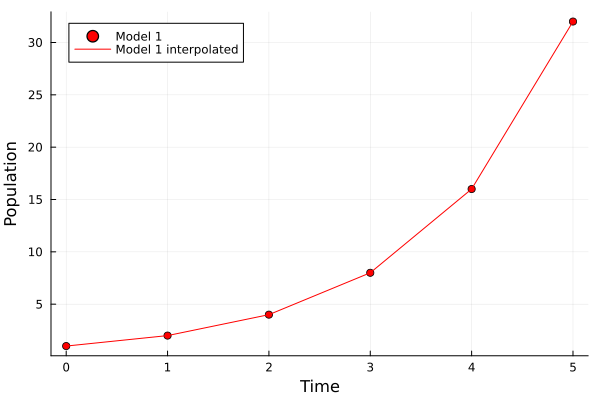

In [9]:
#Plotting Model 1
t_grid = 0:0.01:default_t_max
traj1_on_grid = [value_at_time(traj1,t1) for t1 in t_grid] 
p1 = scatter(traj1.t,traj1.u, c=:red,legend=:topleft,label="Model 1",xlabel="Time",ylabel="Population")
p2 = plot(p1, t_grid, traj1_on_grid, c=:red,legend=:topleft,label="Model 1 interpolated")

### Moving onto Model 2, let's use ODE Solvers

In [10]:
function model_2_traj(;t_max = default_t_max, x0 = default_x0)
    f(x, p, t) = κ_const * x
    ode_prob = ODEProblem(f, x0, (0,t_max))
    ode_sol = solve(ode_prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)
    return ode_sol
end

model_2_traj (generic function with 1 method)

In [11]:
traj2 = model_2_traj()
traj2.t, traj2.u;

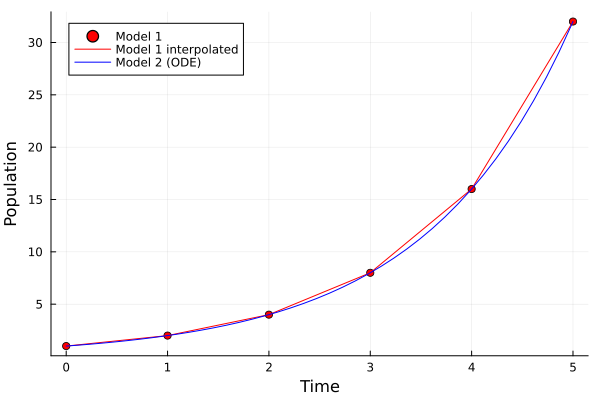

In [12]:
traj2_on_grid = [value_at_time(traj2,t1) for t1 in t_grid] 
p3 = plot(p2, t_grid, traj2_on_grid, c=:blue,legend=:topleft,label="Model 2 (ODE)")

# Going stochastic...

In [13]:
function model_3_traj(;t_max = default_t_max, 
                        x0 = default_x0, 
                        dist_by_mean_generator = Poisson,
                        seed::Union{Nothing,Int} = nothing)
    !isnothing(seed) && Random.seed!(seed)
    dist = dist_by_mean_generator(α_const)
    traj = Array{Float64}(undef, t_max+1)
    x = x0
    traj[1] = x
    for t in 2:(t_max+1)
        offsprings = [rand(dist) for _ in 1:x]
        x = isempty(offsprings) ? 0 : sum(offsprings)
        traj[t] = x
    end
    return ModelTrajectory(0:t_max, traj)
end

model_3_traj (generic function with 1 method)

In [35]:
traj3 = model_3_traj()

ModelTrajectory(0:5, [1.0, 5.0, 7.0, 3.0, 8.0, 10.0])

In [36]:
traj3_repeats = [model_3_traj().u for _ in 1:10^3]

1000-element Vector{Vector{Float64}}:
 [1.0, 2.0, 10.0, 26.0, 55.0, 116.0]
 [1.0, 5.0, 13.0, 16.0, 43.0, 96.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 5.0, 11.0, 31.0, 52.0, 104.0]
 [1.0, 2.0, 2.0, 6.0, 13.0, 20.0]
 [1.0, 2.0, 3.0, 9.0, 22.0, 43.0]
 [1.0, 1.0, 1.0, 1.0, 5.0, 7.0]
 [1.0, 2.0, 5.0, 10.0, 21.0, 33.0]
 [1.0, 1.0, 2.0, 3.0, 8.0, 13.0]
 [1.0, 4.0, 6.0, 5.0, 11.0, 17.0]
 [1.0, 4.0, 10.0, 22.0, 59.0, 99.0]
 [1.0, 2.0, 12.0, 22.0, 43.0, 85.0]
 ⋮
 [1.0, 1.0, 2.0, 1.0, 1.0, 2.0]
 [1.0, 2.0, 1.0, 2.0, 2.0, 4.0]
 [1.0, 3.0, 3.0, 6.0, 12.0, 20.0]
 [1.0, 2.0, 4.0, 8.0, 18.0, 35.0]
 [1.0, 4.0, 10.0, 16.0, 35.0, 69.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 4.0, 10.0, 14.0, 19.0, 30.0]
 [1.0, 2.0, 7.0, 9.0, 19.0, 45.0]
 [1.0, 4.0, 9.0, 19.0, 28.0, 51.0]
 [1.0, 2.0, 3.0, 5.0, 10.0, 16.0]
 [1.0, 1.0, 3.0, 4.0, 10.0, 10.0]
 [1.0, 1.0, 2.0, 7.0, 10.0, 17.0]

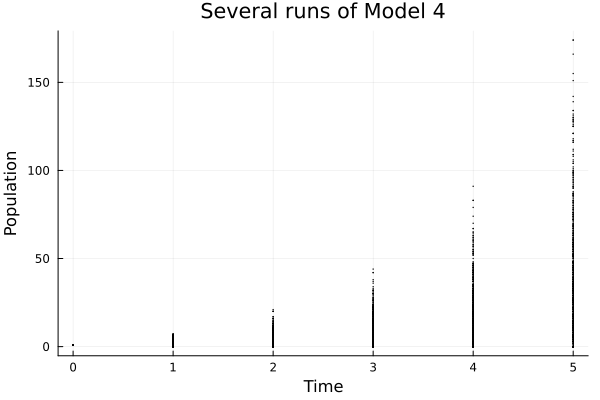

In [37]:
p4 = scatter(traj3.t, hcat(traj3_repeats...), 
        c=:black,ms=0.8,msw=0,legend=:topleft,label=false,xlabel="Time",ylabel="Population",
        title="Several runs of Model 4")

In [38]:
traj3_means = mean(traj3_repeats)

6-element Vector{Float64}:
  1.0
  2.002
  3.968
  8.02
 15.957
 32.065

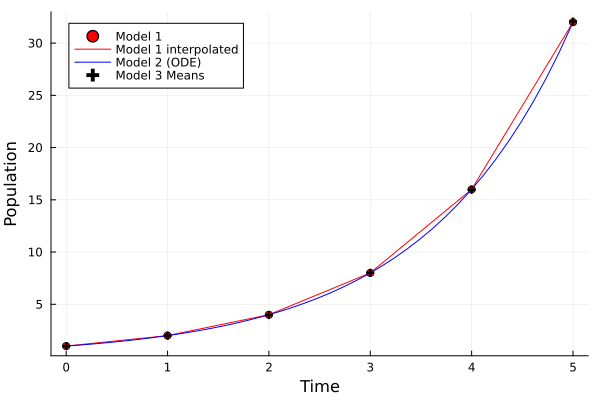

In [39]:
p4 = scatter(p3, traj3.t, traj3_means, c=:black,marker=:cross,legend=:topleft,msw=3,label="Model 3 Means")

Let's increase to a million repeats

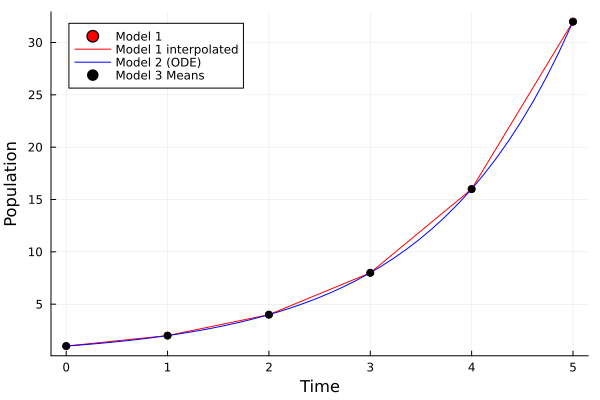

In [40]:
traj3_repeats = [model_3_traj().u for _ in 1:10^6];
traj3_means = mean(traj3_repeats)
p5 = scatter(p3, traj3.t, traj3_means, c=:black,marker=:black,legend=:topleft,msw=2,label="Model 3 Means")

### Now SDE

In [41]:
function model_4_traj(;t_max = default_t_max, x0 = default_x0, dt = 1//2^(4), positive_only = false)
    f(u,p,t) = κ_const*u
    g(u,p,t) = u > 0 ? 1 : 0
    sode_prob = SDEProblem(f,g,x0,(0.0,t_max))
    sode_sol = solve(sode_prob, EM(), dt=dt)
    positive_only ? ModelTrajectory(sode_sol.t, map((u)->max(u,0), sode_sol.u) ) : sode_sol
end

model_4_traj (generic function with 1 method)

In [42]:
traj4_t = model_4_traj().t
first(traj4_t,5)

5-element Vector{Float64}:
 0.0
 0.0625
 0.125
 0.1875
 0.25

In [43]:
traj4_repeats_a = [model_4_traj().u for _ in 1:10^2];
traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^2];

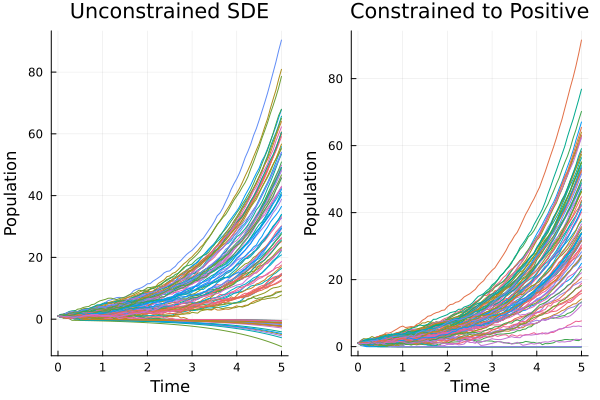

In [44]:
plot_args = (legend=false,xlabel="Time",ylabel="Population")
pa = plot(traj4_t, hcat(traj4_repeats_a...), title = "Unconstrained SDE"; plot_args...)
pb = plot(traj4_t, hcat(traj4_repeats_b...), title = "Constrained to Positive"; plot_args...)
plot(pa,pb)

In [45]:
traj4_repeats_a = [model_4_traj().u for _ in 1:10^5];
traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^5];
traj4_means_a = mean(traj4_repeats_a)
traj4_means_b = mean(traj4_repeats_b)
first(traj4_means_a,3), first(traj4_means_b,3)

([1.0, 1.0414025389341741, 1.0872194360805836], [1.0, 1.0437098303732284, 1.0871199631710726])

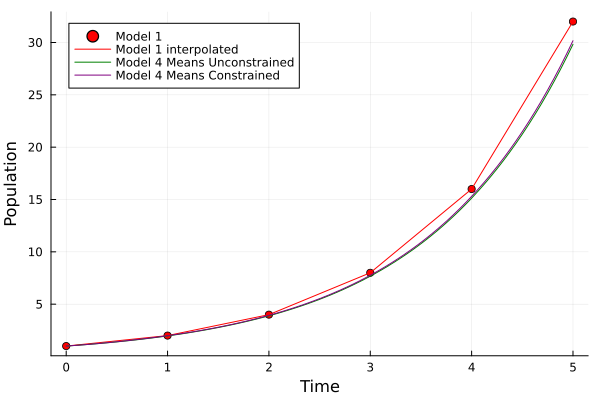

In [46]:
plot(p2, traj4_t, [traj4_means_a traj4_means_b], 
                c=[:green :purple], legend=:topleft, msw=0, 
                label=["Model 4 Means Unconstrained" "Model 4 Means Constrained"])

### Continuous Time Markov Chain (Markov Jump Process)

In [47]:
function model_5_traj(;t_max = default_t_max, x0 = default_x0)
    t, x = 0.0 , x0
    t_values, u_values = [t], [x]
    while t < t_max
        t += rand(Exponential(1/(x*κ_const)))
        x += 1
        push!(t_values,t)
        push!(u_values,x)
    end
    return ModelTrajectory(t_values, u_values)
end

model_5_traj (generic function with 1 method)

In [48]:
traj5 = model_5_traj()
traj5.t, traj5.u

([0.0, 0.5617433526471237, 3.6245660307184093, 4.266827182919237, 4.731967092435591, 5.490573955843627], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0])

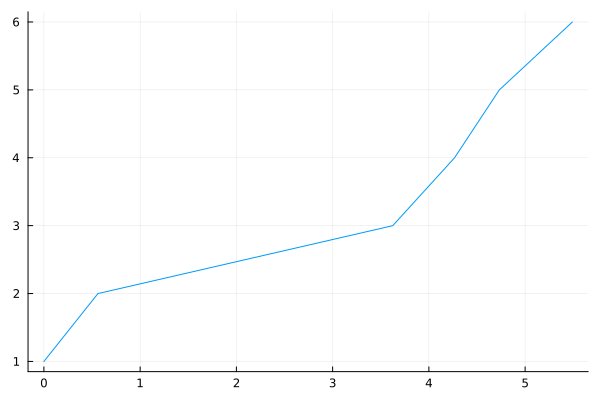

In [49]:
plot(traj5.t, traj5.u, legend=false )

In [50]:
function model_6_traj(;t_max = 10, x0 = 1, life_time_till_doubling_dist = Exponential)
    lives =[]
    t, x = 0.0 , x0
    t_values, u_values = [t], [x]
    while t < t_max
        t += rand(Exponential(1/(x*κ_const)))
        x += 1
        push!(t_values,t)
        push!(u_values,x)
    end
    return ModelTrajectory(t_values, u_values)
end

model_6_traj (generic function with 1 method)

# An Experiment

In [51]:
t4s = [model_3_traj().u[3+1] for _ in 1:10^4];

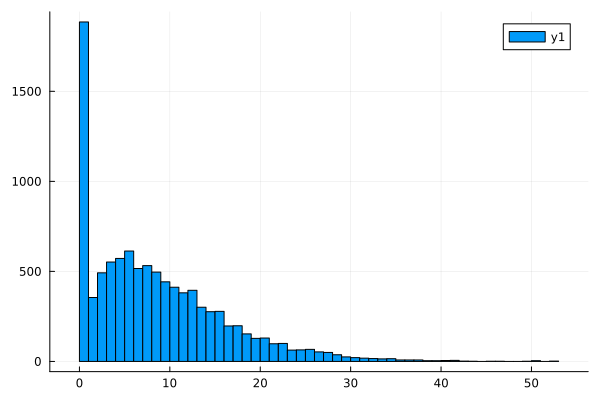

In [52]:
histogram(t4s)

In [53]:
trj = model_4_traj()

retcode: Success
Interpolation: 1st order linear
t: 81-element Vector{Float64}:
 0.0
 0.0625
 0.125
 0.1875
 0.25
 0.3125
 0.375
 0.4375
 0.5
 0.5625
 0.625
 0.6875
 0.75
 ⋮
 4.3125
 4.375
 4.4375
 4.5
 4.5625
 4.625
 4.6875
 4.75
 4.8125
 4.875
 4.9375
 5.0
u: 81-element Vector{Float64}:
  1.0
  0.8857144292340137
  1.0689868756789824
  1.0751814563078002
  1.294416996248485
  1.374862144970581
  1.4318469378729848
  1.0146334362324259
  1.0647937281790911
  1.2109269141741466
  1.4056253707918807
  1.6285364695660083
  1.8188524551421992
  ⋮
 25.900564105237677
 26.557139008488093
 28.166034662243547
 29.050733806025804
 30.979453942386236
 32.64572071591697
 34.08693361549371
 35.89440071593428
 37.649905273341275
 39.50558511827016
 41.28580722214057
 43.00715139770259

In [32]:
findnext((x)->x ≥ 4, trj.t,1)

65

In [33]:
trj.t[63], trj.t[66]

(3.875, 4.0625)

In [34]:
? findfirst

search: findfirst



```
findfirst(A)
```

Return the index or key of the first `true` value in `A`. Return `nothing` if no such value is found. To search for other kinds of values, pass a predicate as the first argument.

Indices or keys are of the same type as those returned by [`keys(A)`](@ref) and [`pairs(A)`](@ref).

See also: [`findall`](@ref), [`findnext`](@ref), [`findlast`](@ref), [`searchsortedfirst`](@ref).

# Examples

```jldoctest
julia> A = [false, false, true, false]
4-element Vector{Bool}:
 0
 0
 1
 0

julia> findfirst(A)
3

julia> findfirst(falses(3)) # returns nothing, but not printed in the REPL

julia> A = [false false; true false]
2×2 Matrix{Bool}:
 0  0
 1  0

julia> findfirst(A)
CartesianIndex(2, 1)
```

---

```
findfirst(predicate::Function, A)
```

Return the index or key of the first element of `A` for which `predicate` returns `true`. Return `nothing` if there is no such element.

Indices or keys are of the same type as those returned by [`keys(A)`](@ref) and [`pairs(A)`](@ref).

# Examples

```jldoctest
julia> A = [1, 4, 2, 2]
4-element Vector{Int64}:
 1
 4
 2
 2

julia> findfirst(iseven, A)
2

julia> findfirst(x -> x>10, A) # returns nothing, but not printed in the REPL

julia> findfirst(isequal(4), A)
2

julia> A = [1 4; 2 2]
2×2 Matrix{Int64}:
 1  4
 2  2

julia> findfirst(iseven, A)
CartesianIndex(2, 1)
```

---

```
findfirst(pattern::AbstractString, string::AbstractString)
findfirst(pattern::AbstractPattern, string::String)
```

Find the first occurrence of `pattern` in `string`. Equivalent to [`findnext(pattern, string, firstindex(s))`](@ref).

# Examples

```jldoctest
julia> findfirst("z", "Hello to the world") # returns nothing, but not printed in the REPL

julia> findfirst("Julia", "JuliaLang")
1:5
```

---

```
findfirst(ch::AbstractChar, string::AbstractString)
```

Find the first occurrence of character `ch` in `string`.

!!! compat "Julia 1.3"
    This method requires at least Julia 1.3.


# Examples

```jldoctest
julia> findfirst('a', "happy")
2

julia> findfirst('z', "happy") === nothing
true
```

---

```
findfirst(pattern::AbstractVector{<:Union{Int8,UInt8}},
          A::AbstractVector{<:Union{Int8,UInt8}})
```

Find the first occurrence of sequence `pattern` in vector `A`.

!!! compat "Julia 1.6"
    This method requires at least Julia 1.6.


# Examples

```jldoctest
julia> findfirst([0x52, 0x62], [0x40, 0x52, 0x62, 0x63])
2:3
```
